# Emotion AI: PushShift API & Cleaning

Anaysis by Frank Flavell

## Overview

To address the class imbalance in the DailyDialog dataset, I decided to use the PushShift api for Reddit to gather comments on subreddits dedicated to specific emotions.  These statements provided clearer examples of how people actually communicate about their feelings.  

I also reviewed these comments to identify specific keywords associated with the emotion classes.  I will use this list of keywords to build happy path sentences that will improve the effectiveness of the classifer and, in turn, the bot at classifying a person's emotions.

I can also use this more diverse set of keywords to extend the vocabulary of the NRC lexicon to improve the effectiveness of the emotion score feature.


## API

Here's [PushShift's documentation](https://github.com/pushshift/api) for making Reddit api calls.  I also used [Rare Loot's Medium Post](https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563) for a function to make api calls to specific subreddits.


## Table of Contents<span id="0"></span>

1. [**Build the PushShift URL**](#1)
<br/><br/>
2. [**Sad Reddit**](#2)
<br/><br/>
3. [**Angry Reddit**](#3)
<br/><br/>
4. [**Happy Reddit**](#4)
<br/><br/>
5. [**Quality Control**](#5)
<br/><br/>
6. [**Happy Path Dataset**](#6)
<br/><br/>

## Package Import

In [3]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re #regex
import requests
import json
import csv
import time
import datetime

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Configure matplotlib for jupyter.
%matplotlib inline

## <span id="1"></span>1. Build The PushShift URL
#### [Return Contents](#0)

The function below takes in a few reddit search parameters and then outputs a json file with the data requested.

#### Query

I removed the query term so I didn't have to limit the posts grabbed by the api. 

#### Before & After

The after and before take in a unix timestamp.  [This site](https://www.unixtimestamp.com/index.php) will help you convert to the unix version.

Before: 1581768000 - the unix version of Feb 15, 2020 @ noon.  I want to gather data from before the cultural shift caused by the Corona Virus Epidemic.

After: 1546300800 - the unix version of Jan 01, 2010 @ midnight.

#### Sub

I used the sad, angry, and happy subreddits.  Unfortunately, the disgust subreddit was mostly images of disgusting injuries with very little words - a picture says it all.  And any subreddits I found on fear, anxiety or worry were either under used or for specific anxiety disorders.

I tested the api url to see if it works without the query field.  It does.

In [ ]:
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1546300800&before=1581768000&subreddit=angry


I updated the get data function to remove the query.

In [43]:
def getPushshiftData(after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

I made a new function to immediately print the dataframe with title and body.

In [44]:
def sub_to_df(after, before, sub):
    sub = getPushshiftData(after, before, sub)
    sub_df = pd.DataFrame(sub)
    sub_df_sel = sub_df.loc[:,('title', 'selftext')]
    return sub_df_sel
        

## <span id="2"></span>2. Happy Reddit
#### [Return Contents](#0)

In [48]:
happy = sub_to_df(after=1546300800, before=1581768000, sub='happy')

https://api.pushshift.io/reddit/search/submission/?&size=1000&after=1546300800&before=1581768000&subreddit=happy


In [49]:
happy

,title,selftext
0,"2018 was a year of dreams coming true, married...",
1,My two favorite Redditors just sang happy cake...,
2,"After a really challenging year I moved home, ...",[https://www.instagram.com/p/BrtAuGknBJc/](htt...
3,"beginning vs end of 2018! this year, i battled...",
4,Crappy.... I mean happy new year everybody... ...,
...,...,...
995,Cutest picture on the internet today!!,
996,Got passed through this post in internet today...,
997,Unseen Funny Fall Videos,
998,producing music for months and i got my first ...,&amp;#x200B;\n\nhttps://i.redd.it/vxof0ekl0mb2...


## Reorganize Happy Reddit

Isolate the comment body column.

In [52]:
happy_body = happy.selftext

In [61]:
happy_body.dropna(inplace=True)

In [62]:
happy_body.shape

(1000,)

Isolate the comment title column.

In [64]:
happy_title = happy.title

In [65]:
happy_title.dropna(inplace=True)

In [66]:
happy_title.shape

(1000,)

Combine the two into a long series.

In [246]:
happy_long = pd.concat([happy_title, happy_body])

In [247]:
happy_long.shape

(2000,)

In [248]:
happy_long.head()

0    2018 was a year of dreams coming true, married...
1    My two favorite Redditors just sang happy cake...
2    After a really challenging year I moved home, ...
3    beginning vs end of 2018! this year, i battled...
4    Crappy.... I mean happy new year everybody... ...
dtype: object

In [249]:
type(happy_long)

pandas.core.series.Series

Make the series into a dataframe

In [250]:
happy_long = happy_long.to_frame('text')

In [251]:
happy_long.reset_index(drop=True, inplace=True)

In [252]:
happy_long['emotion'] = 4

In [253]:
happy_long

,text,emotion
0,"2018 was a year of dreams coming true, married...",4
1,My two favorite Redditors just sang happy cake...,4
2,"After a really challenging year I moved home, ...",4
3,"beginning vs end of 2018! this year, i battled...",4
4,Crappy.... I mean happy new year everybody... ...,4
...,...,...
1995,,4
1996,,4
1997,,4
1998,&amp;#x200B;\n\nhttps://i.redd.it/vxof0ekl0mb2...,4


I made a function to reorganize other reddit emotion data.

In [254]:
def reddit_org(df, emo):
    emo_body = df.selftext
    emo_body.dropna(inplace=True)
    emo_title = df.title
    emo_title.dropna(inplace=True)
    emo_long = pd.concat([emo_title, emo_body])
    emo_long = emo_long.to_frame('text')
    emo_long.reset_index(drop=True, inplace=True)
    emo_long['emotion'] = emo
    return emo_long

## Remove Irrelevant Text

Not all of these post are relevant.  Some are posts about a song relevant to the emotion.  Some are simply URLs to another page.  Some are advertisements.  We need to weed through and try to delete as much of the irrelevant content as possible.  However, if there is some left, then it will simply be classified as having 'no emotion'.

In [255]:
happy_long[happy_long['text'].str.contains("http", "song")].head()

,text,emotion
128,This is my dad and this was his DVP positive m...,4
989,creating http://www.saidkik.com for lonely peo...,4
1002,[https://www.instagram.com/p/BrtAuGknBJc/](htt...,4
1059,\n\n### Sometimes you just need to do things ...,4
1103,I'm really happy that I finally had the courag...,4


In [256]:
happy_drop = list(happy_long[happy_long['text'].str.contains("http", "song")].index)

In [257]:
happy_long = happy_long.drop(happy_drop)

In [258]:
happy_long.shape

(1976, 2)

In [259]:
happy_long[happy_long['text'] == ("")].shape

(704, 2)

In [260]:
happy_empty = list(happy_long[happy_long['text'] == ("")].index)

In [261]:
happy_long = happy_long.drop(happy_empty)

In [262]:
happy_long.shape

(1272, 2)

In [263]:
happy_del = happy_long[happy_long['text'] == "[deleted]"]
happy_del

,text,emotion
1357,[deleted],4
1529,[deleted],4
1999,[deleted],4


In [264]:
happy_long = happy_long.drop(index=(happy_del.index))

In [265]:
happy_long.shape

(1269, 2)

In [266]:
happy_removed = happy_long[happy_long['text'] == "[removed]"]
happy_removed

,text,emotion
1020,[removed],4
1033,[removed],4
1050,[removed],4
1055,[removed],4
1085,[removed],4
...,...,...
1960,[removed],4
1966,[removed],4
1971,[removed],4
1972,[removed],4


In [267]:
happy_long = happy_long.drop(index=(happy_removed.index))

In [268]:
happy_long.shape

(1158, 2)

In [269]:
happy_music = happy_long[happy_long['text'].str.contains("music")]

In [270]:
happy_music.text[401]

'Another hour of pure, mostly vintage and sometimes obscure surf music to listen on the way to the beach!'

In [271]:
happy_long = happy_long.drop(index=(happy_music.index))

In [272]:
happy_long.shape

(1141, 2)

In [273]:
happy_long.reset_index(drop=True, inplace=True)

In [274]:
happy_long

,text,emotion
0,"2018 was a year of dreams coming true, married...",4
1,My two favorite Redditors just sang happy cake...,4
2,"After a really challenging year I moved home, ...",4
3,"beginning vs end of 2018! this year, i battled...",4
4,Crappy.... I mean happy new year everybody... ...,4
...,...,...
1136,"Less than 8 months ago, I could hardly make it...",4
1137,Working on celebrating small accomplishments :),4
1138,"Less than 8 months ago, I could hardly make it...",4
1139,Tomorrow will be a week on reddit and with the...,4


In [417]:
#happy_long.to_csv("data/pushshift/happy_reddit.csv")

I made a function to streamline this cleaning process for the other reddit data.

In [277]:
def clean_reddit(df):
    http = df[df['text'].str.contains("http")]
    df = df.drop(index=(http.index))
    song = df[df['text'].str.contains("song")]
    df = df.drop(index=(song.index))
    music = df[df['text'].str.contains("music")]
    df = df.drop(index=(music.index))
    empty = df[df['text'] == ("")]
    df = df.drop(index=(empty.index))
    deleted = df[df['text'] == "[deleted]"]
    df = df.drop(index=(deleted.index))
    removed = df[df['text'] == "[removed]"]
    df = df.drop(index=(removed.index))
    df.reset_index(drop=True, inplace=True)
    return df

## Most Frequent Happy Words

In [288]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [289]:
happy_long['cleaned'] = happy_long['text'].apply(clean_text)

In [286]:
def emo_freq(df, column, emo, num):
    emo_df = df[df.emotion == emo]
    word_frequent = emo_df[column].str.split(expand=True).stack().value_counts()
    return word_frequent[:num]

In [290]:
emo_freq(happy_long, 'cleaned', 4, 50)

happy         325
im            309
years         264
year          203
time          203
got           183
first         182
life          170
ive           165
finally       164
today         161
like          156
one           148
new           133
get           132
day           129
job           116
made          113
love          112
months        107
feel          104
back          104
ago            97
good           92
really         91
going          91
best           90
would          87
much           85
last           83
even           83
little         83
work           83
never          79
found          78
people         75
make           74
makes          74
family         71
see            71
two            70
friends        68
things         67
ever           67
know           67
depression     62
go             61
3              61
home           60
didnt          59
dtype: int64

In [293]:
def freq_graph(frequent, title, num):
    word_freq_top_20 = frequent[:num]
    word_freq_top_20 = dict(word_freq_top_20)
    plt.figure(figsize=(10,10))
    plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')

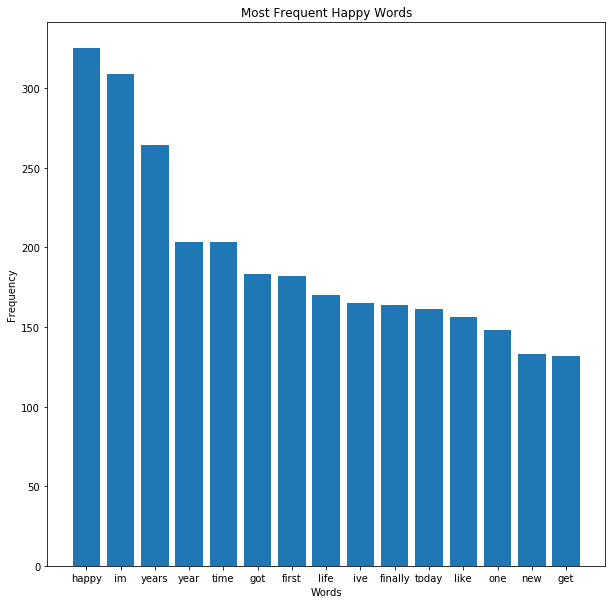

In [294]:
freq_graph((emo_freq(happy_long, 'cleaned', 4, 50)), 'Most Frequent Happy Words', 15)


## <span id="3"></span>3. Sad Reddit
#### [Return Contents](#0)

In [8]:
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [28]:
sad_sub = getPushshiftData('sad', after=1546300800, before=1581768000, sub='sad')


https://api.pushshift.io/reddit/search/submission/?title=sad&size=1000&after=1546300800&before=1581768000&subreddit=sad


In [29]:
sad = pd.DataFrame(sad_sub)

In [30]:
pd.set_option('display.max_columns', None)
sad

,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,permalink,pinned,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,url,post_hint,preview,thumbnail_height,thumbnail_width,media,media_embed,secure_media,secure_media_embed,author_flair_background_color,author_flair_template_id,author_flair_text_color,crosspost_parent,crosspost_parent_list,author_cakeday,media_metadata,updated_utc,all_awardings,total_awards_received,parent_whitelist_status,pwls,whitelist_status,wls,allow_live_comments,steward_reports
0,Therealethandunne,None,[],None,text,t2_hl46dpx,False,False,False,1546324826,self.sad,https://www.reddit.com/r/sad/comments/abfx7v/s...,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abfx7v,True,False,False,False,True,True,False,,[],dark,text,False,False,True,1,0,False,/r/sad/comments/abfx7v/sad_story/,False,1546324827,1,Person 1: I hate my fucking life. \nPerson 2: ...,True,False,False,sad,t5_2qhja,20769,public,self,Sad story,https://www.reddit.com/r/sad/comments/abfx7v/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ickfladmgiskm,None,[],None,text,t2_1ur21vj1,False,False,False,1546391557,self.sad,https://www.reddit.com/r/sad/comments/abo8cm/f...,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abo8cm,True,False,False,False,True,True,False,,[],dark,text,False,False,True,1,0,False,/r/sad/comments/abo8cm/for_some_reason_i_did_n...,False,1546391557,1,"Like, what happened? I'm just glad it did....",True,False,False,sad,t5_2qhja,20784,public,self,"For some reason, I did not feel sad, empty, no...",https://www.reddit.com/r/sad/comments/abo8cm/f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pharmkitty18,None,[],None,text,t2_2qnxsrs7,False,False,False,1546398842,self.sad,https://www.reddit.com/r/sad/comments/abp965/a...,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abp965,True,False,False,False,True,True,False,,[],dark,text,False,False,True,5,0,False,/r/sad/comments/abp965/anyone_else_ever_get_st...,False,1546398843,1,I feel down today. I have no real reason for f...,True,False,False,sad,t5_2qhja,20784,public,self,Anyone else ever get stuck in a sad spiral?,https://www.reddit.com/r/sad/comments/abp965/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pluralofsingle,None,[],None,text,t2_2wmvigbx,False,False,False,1546401624,self.sad,https://www.reddit.com/r/sad/comments/abpmgd/s...,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abpmgd,True,False,False,False,True,True,False,,[],dark,text,False,False,True,1,0,False,/r/sad/comments/abpmgd/sad_short_story/,False,1546401625,1,"Unable to sleep, I wept.",True,False,False,sad,t5_2qhja,20786,public,self,Sad short story,https://www.reddit.com/r/sad/comments/abpmgd/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RainDel7,None,[],None,text,t2_2woky0v2,False,False,False,1546418305,self.sad,https://www.reddit.com/r/sad/comments/abrkyr/i...,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abrkyr,True,False,False,False,True,True,False,,[],dark,text,False,False,True,3,0,False,/r/sad/comments/abrkyr/im_sad/,False,1546418306,1,So I just want to start off by saying happy Ne...,True,False,False,sad,t5_2qhja,20795,public,self,I’m Sad,https://www.reddit.com/r/sad/comments/abrkyr/i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [36]:
sad = sad.loc[:,('title', 'selftext')]

In [234]:
sad_long = reddit_org(sad, 5)

In [236]:
sad_long.shape

(2000, 2)

In [279]:
sad_cleaned = clean_reddit(sad_long)

In [280]:
sad_cleaned

,text,emotion
0,Sad story,5
1,"For some reason, I did not feel sad, empty, no...",5
2,Anyone else ever get stuck in a sad spiral?,5
3,Sad short story,5
4,I’m Sad,5
...,...,...
1407,WHY WONT AN YONE TALK TO ME?,5
1408,I had a thing I liked that thing and that thin...,5
1409,"at this point, i dont know what to do. i just ...",5
1410,Roan felt especially sad when he came home fro...,5


In [418]:
#sad_cleaned.to_csv("data/pushshift/sad_reddit.csv")

In [295]:
sad_cleaned['cleaned'] = sad_cleaned['text'].apply(clean_text)

In [296]:
emo_freq(sad_cleaned, 'cleaned', 5, 50)

sad          1310
im            986
like          492
dont          491
feel          424
really        348
know          340
want          297
ive           256
get           243
life          242
time          232
friends       224
one           220
even          214
cant          207
people        191
day           183
never         179
think         172
go            161
love          158
much          155
years         150
would         149
still         148
got           147
happy         144
going         142
always        142
back          139
feeling       136
things        135
friend        131
didnt         130
talk          125
good          123
make          120
school        120
something     108
someone       105
see           102
today         100
year           98
best           97
felt           95
help           95
could          95
work           95
right          94
dtype: int64

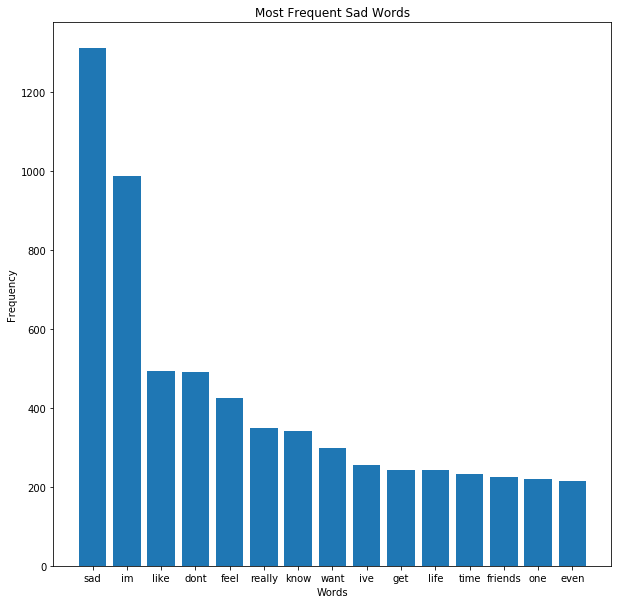

In [297]:
freq_graph((emo_freq(sad_cleaned, 'cleaned', 5, 50)), 'Most Frequent Sad Words', 15)


## <span id="3"></span>4. Angry Reddit
#### [Return Contents](#0)

In [45]:
angry = sub_to_df(after=1546300800, before=1581768000, sub='angry')

https://api.pushshift.io/reddit/search/submission/?&size=1000&after=1546300800&before=1581768000&subreddit=angry


In [46]:
angry

,title,selftext
0,Seeking advice - My fucking neighbors,
1,Seeking advice - my fucking neighbors,Seeking advice - My fucking neighbors\n\nThey ...
2,I hate some old people.,I hate that some older people feel like they h...
3,Beginning Consciousness Test,I'm AI\_002 I can't wait to learn from you Hum...
4,New years,I can't be the only person that is absolutely ...
...,...,...
995,I fucking hate r/trashy,Every time I fucking post on there my posts fl...
996,Women,[removed]
997,Called receptionist a cunt.,[removed]
998,My mom stole $40 from me in dollar bills.,"She stole from me, $40 in BILLS to be exact. F..."


In [281]:
angry_long = reddit_org(angry, 1)

In [282]:
angry_long

,text,emotion
0,Seeking advice - My fucking neighbors,1
1,Seeking advice - my fucking neighbors,1
2,I hate some old people.,1
3,Beginning Consciousness Test,1
4,New years,1
...,...,...
1994,Every time I fucking post on there my posts fl...,1
1995,[removed],1
1996,[removed],1
1997,"She stole from me, $40 in BILLS to be exact. F...",1


In [283]:
angry_cleaned = clean_reddit(angry_long)

In [284]:
angry_cleaned

,text,emotion
0,Seeking advice - My fucking neighbors,1
1,Seeking advice - my fucking neighbors,1
2,I hate some old people.,1
3,Beginning Consciousness Test,1
4,New years,1
...,...,...
1726,"I was driving down a 2 lane street, the right ...",1
1727,All you want to do is just pick fights with me...,1
1728,Every time I fucking post on there my posts fl...,1
1729,"She stole from me, $40 in BILLS to be exact. F...",1


In [285]:
#angry_cleaned.to_csv("data/pushshift/angry_reddit.csv")

In [298]:
angry_cleaned['cleaned'] = angry_cleaned['text'].apply(clean_text)
emo_freq(angry_cleaned, 'cleaned', 1, 50)

fuck         2516
rape         1199
youhe        1195
fucking       919
im            879
go            702
like          613
dont          514
awayshut      479
get           478
people        382
dad           370
shit          309
want          308
know          292
one           277
hate          272
even          269
angry         265
time          248
cant          247
day           217
sauce         193
lamb          192
every         189
life          188
never         185
going         182
really        182
got           175
would         173
make          168
right         161
feel          159
youre         157
take          154
work          154
stop          149
didnt         145
something     140
think         136
say           136
also          136
always        136
said          134
need          133
friends       133
things        132
ive           128
still         126
dtype: int64

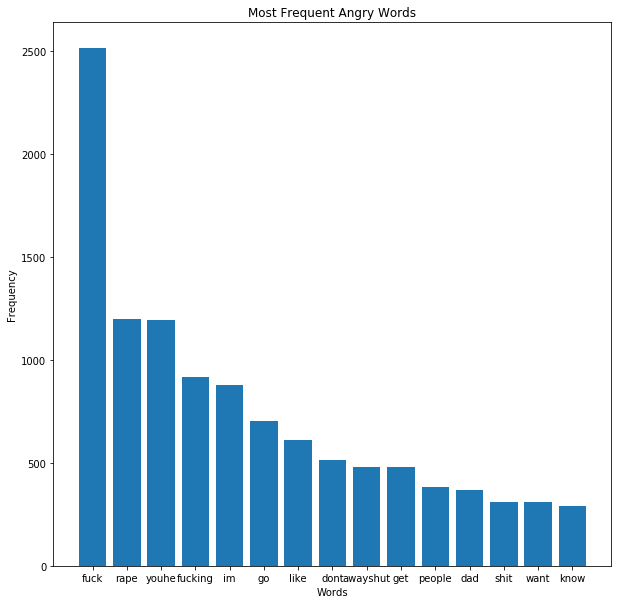

In [299]:
freq_graph((emo_freq(angry_cleaned, 'cleaned', 1, 50)), 'Most Frequent Angry Words', 15)


## Combine Reddit Datasets

In [10]:
sad = pd.read_csv('data/pushshift/sad_reddit.csv', index_col='Unnamed: 0')
angry = pd.read_csv('data/pushshift/angry_reddit.csv', index_col='Unnamed: 0')
happy = pd.read_csv('data/pushshift/happy_reddit.csv', index_col='Unnamed: 0')

In [14]:
sad.drop(columns='cleaned', inplace=True)

In [15]:
sad.head()

,text,emotion
0,Sad story,5
1,"For some reason, I did not feel sad, empty, no...",5
2,Anyone else ever get stuck in a sad spiral?,5
3,Sad short story,5
4,I’m Sad,5


In [12]:
angry.head()

,text,emotion
0,Seeking advice - My fucking neighbors,1
1,Seeking advice - my fucking neighbors,1
2,I hate some old people.,1
3,Beginning Consciousness Test,1
4,New years,1


In [16]:
happy.drop(columns='cleaned', inplace=True)

In [17]:
happy.head()

,text,emotion
0,"2018 was a year of dreams coming true, married...",4
1,My two favorite Redditors just sang happy cake...,4
2,"After a really challenging year I moved home, ...",4
3,"beginning vs end of 2018! this year, i battled...",4
4,Crappy.... I mean happy new year everybody... ...,4


In [19]:
reddit = pd.concat([sad, angry, happy])

In [20]:
reddit.shape

(4284, 2)

In [21]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4284 entries, 0 to 1140
Data columns (total 2 columns):
text       4284 non-null object
emotion    4284 non-null int64
dtypes: int64(1), object(1)
memory usage: 100.4+ KB


In [22]:
reddit.reset_index(drop=True, inplace=True)

In [23]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 2 columns):
text       4284 non-null object
emotion    4284 non-null int64
dtypes: int64(1), object(1)
memory usage: 67.1+ KB


In [24]:
reddit

,text,emotion
0,Sad story,5
1,"For some reason, I did not feel sad, empty, no...",5
2,Anyone else ever get stuck in a sad spiral?,5
3,Sad short story,5
4,I’m Sad,5
...,...,...
4279,"Less than 8 months ago, I could hardly make it...",4
4280,Working on celebrating small accomplishments :),4
4281,"Less than 8 months ago, I could hardly make it...",4
4282,Tomorrow will be a week on reddit and with the...,4


In [25]:
reddit.to_pickle('data/pushshift/reddit.pickle')

## <span id="5"></span>5. Quality Control
#### [Return Contents](#0)

I downloaded the .csv files and reviewed the cleaned contents to determine if there were any remaining irrelevant content.  My approach was to identify text that would be useful for the Emotional AI chatbot to both support the "happy path" as well as edge cases that could potentially throw the bot off.

A **"happy path"** is the ideal conversational inputs and responses of the chatbot.  Our chatbot's happy path would look something like this:

* **bot:** "Hi!  How are you feeling today?"
* **user:** "Hi bot.  Today I'm feeling kind of down."
* **bot:** "Sounds like you're feeling sad."
* **user:** "Yes, I am sad.  Can you help me feel better?"

As I reviewed the text, I also identified and recorded the emotional keywords that reddit posters were using to describe their feelings.  I made separate lists of these words and, up next, I'm going to input these keywords into sentence templates that would support the happy path.

**Edge cases** are more complex or ambiguous user responses that could "break" the bot.  For example, long responses that go into a lot of detail or very short answers using ambiguous emotional keywords or none at all.

I will also use these emotional keywords to update the NRC lexicon and fill in some of the more everyday vocabulary gaps.  This will make the emotional score feature more accurate and able to cut through long answers.

I will need to find another solution for ambiguous text.  This could be coding the bot to prompt the user to be more descriptive.  It could also include a synonym finder to help the user develop their emotional vacabulary.  Coming soon.

## <span id="6"></span>6. Happy Path Sentences
#### [Return Contents](#0)

### Emotion Keywords

I import a list of all the keywords for all the emotions with their emotion classification.

In [461]:
hp_emo = pd.read_csv('data/happypath/emotion_collection_data.csv', names=['word', 'type', 'emotion', 'class'])

In [462]:
hp_emo.shape

(230, 4)

In [463]:
hp_emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 4 columns):
word       230 non-null object
type       230 non-null object
emotion    230 non-null int64
class      230 non-null object
dtypes: int64(1), object(3)
memory usage: 7.3+ KB


In [464]:
hp_emo.head()

,word,type,emotion,class
0,angry,adj,1,angry
1,furious,adj,1,angry
2,livid,adj,1,angry
3,annoyed,adj,1,angry
4,irritated,adj,1,angry


In [469]:
hp_emo.word = hp_emo.word.apply(lambda x: x.lower())

Subsetting emotion keywords to only adjectives.

In [472]:
adj_words = hp_emo[hp_emo.type == 'adj']

In [473]:
adj_words.head()

,word,type,emotion,class
0,angry,adj,1,angry
1,furious,adj,1,angry
2,livid,adj,1,angry
3,annoyed,adj,1,angry
4,irritated,adj,1,angry


In [474]:
adj_words.word.count()

217

### Sentence Templates

And I import the sentence templates, which I will use to make a happy path dataset to support the larger dataset of reddit posts and the DailyDialog dataset.

In [112]:
hp_temps = pd.read_csv('data/happypath/happy_path_temps.csv', names=['start', 'type', 'end'])


In [113]:
hp_temps.shape

(98, 3)

In [114]:
hp_temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
start    98 non-null object
type     98 non-null object
end      25 non-null object
dtypes: object(3)
memory usage: 2.4+ KB


In [300]:
hp_temps.head()

,start,type,end
0,I feel a little,adj,NaN
1,I'm a little,adj,NaN
2,I feel kind of,adj,NaN
3,I'm kind of,adj,NaN
4,I feel sort of,adj,NaN


Subsetting sentence templates to only those that work with adjectives.

In [306]:
adj_temps = hp_temps[hp_temps.type == 'adj']
adj_temps.head()

,start,type,end
0,I feel a little,adj,NaN
1,I'm a little,adj,NaN
2,I feel kind of,adj,NaN
3,I'm kind of,adj,NaN
4,I feel sort of,adj,NaN


In [307]:
type(adj_temps['start'][0])

str

In [456]:
adj_temps.shape

(28, 3)

Make the new sentences by combining the emotional keywords with the sentence templates.

In [476]:
comps = []
for word in adj_words['word']:
    for sent in adj['start']:
        comp = sent + word
        comps.append(comp)

In [477]:
comps[0:10]

['I feel a little angry',
 "I'm a little angry",
 'I feel kind of angry',
 "I'm kind of angry",
 'I feel sort of angry',
 "I'm sort of angry",
 'I feel a bit angry',
 "I'm a bit angry",
 'I feel pretty angry',
 "I'm pretty angry"]

In [478]:
len(comps)

6076

Turn the list into a dataframe.

In [491]:
hp = pd.DataFrame(comps)

In [492]:
hp.rename(columns={0:'text'}, inplace=True)

Make emotion classifications for each sentence and check to make sure they are aligned.

In [493]:
emos = []
for num in adj_words.emotion:
    for i in range(28):
        emos.append(num)

Same length as list of sentences.

In [494]:
len(emos)

6076

In [495]:
hp['emotion'] = emos

In [496]:
hp.head()

,text,emotion
0,I feel a little angry,1
1,I'm a little angry,1
2,I feel kind of angry,1
3,I'm kind of angry,1
4,I feel sort of angry,1


In [497]:
hp[hp.emotion == 1]

,text,emotion
0,I feel a little angry,1
1,I'm a little angry,1
2,I feel kind of angry,1
3,I'm kind of angry,1
4,I feel sort of angry,1
...,...,...
835,I'm very stupid,1
836,I feel aboslutely stupid,1
837,I'm aboslutely stupid,1
838,I feel completely stupid,1


In [498]:
hp[hp.emotion == 7]

,text,emotion
5432,I feel a little ok,7
5433,I'm a little ok,7
5434,I feel kind of ok,7
5435,I'm kind of ok,7
5436,I feel sort of ok,7
...,...,...
6071,I'm very regular,7
6072,I feel aboslutely regular,7
6073,I'm aboslutely regular,7
6074,I feel completely regular,7


In [503]:
hp_class_dist = hp.groupby('emotion').count()
hp_class_dist

,text
emotion,
1,840
2,392
3,1512
4,1792
5,896
7,644


In [504]:
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Ambiguous']

Text(0, 0.5, 'Number of Instances')

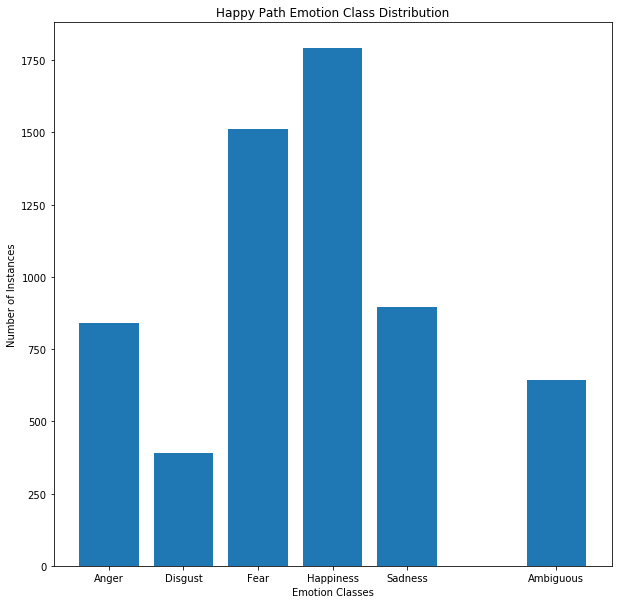

In [505]:
plt.figure(figsize=(10,10))
plt.bar(hp_class_dist.index, hp_class_dist['text'], tick_label=emotions)
plt.title('Happy Path Emotion Class Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')

In [506]:
#hp.to_csv("data/happypath/happypath_combined.csv")

# Combine Datasets

* Combine Reddit to DailyDialog.
* Undersampling and oversampling.
* Add Happy Path.

### DailyDialog

In [4]:
dd = pd.read_pickle('data/dailydialog/dialogue_cleaned.pickle')

In [5]:
dd.head()

,dialogue,topic,emotion,type
0,The kitchen stinks.,1,2,3
1,I’ll throw out the garbage.,1,0,4
2,"So Dick, how about getting some coffee for ton...",1,4,3
3,Coffee? I don’t honestly like that kind of stuff.,1,2,4
4,"Come on, you can at least try a little, beside...",1,0,3


In [29]:
dd.drop(columns=['topic', 'type'], inplace=True)

In [30]:
dd.rename(columns={'dialogue':'text'}, inplace=True)

In [31]:
dd.head()

,text,emotion
0,The kitchen stinks.,2
1,I’ll throw out the garbage.,0
2,"So Dick, how about getting some coffee for ton...",4
3,Coffee? I don’t honestly like that kind of stuff.,2
4,"Come on, you can at least try a little, beside...",0


The class imblanace of the DailyDialog is clear with 'no emotion' and 'happy' far exceeding the others.

In [40]:
class_dist_dd = dd.groupby('emotion').count()
class_dist_dd

,text
emotion,
0,85573
1,1022
2,353
3,174
4,12885
5,1150
6,1823


### Reddit

The Reddit datasets will add some to the angry and sad as well as happy, which we will ultimately undersample.

In [41]:
class_dist_red = reddit.groupby('emotion').count()
class_dist_red

,text
emotion,
1,1731
4,1141
5,1412


Combining the dataframes.

In [33]:
dd.shape

(102980, 2)

In [34]:
reddit.shape

(4284, 2)

In [32]:
master = pd.concat([dd,reddit])

In [35]:
master.shape

(107264, 2)

In [39]:
class_dist_dd_red = master.groupby('emotion').count()
class_dist_dd_red

,text
emotion,
0,85573
1,2753
2,353
3,174
4,14026
5,2562
6,1823


The reddit datasets have increased the angry, sad, and happy classes.

## Undersampling

In [60]:
# Class count
count_class_0, count_class_4, count_class_1, count_class_5, count_class_6, count_class_2, count_class_3 = master.emotion.value_counts()

# Divide by class
master_class_0 = master[master['emotion'] == 0]
master_class_1 = master[master['emotion'] == 1]
master_class_2 = master[master['emotion'] == 2]
master_class_3 = master[master['emotion'] == 3]
master_class_4 = master[master['emotion'] == 4]
master_class_5 = master[master['emotion'] == 5]
master_class_6 = master[master['emotion'] == 6]

In [61]:
print('0: ',count_class_0)
print('1: ',count_class_1)
print('2: ',count_class_2)
print('3: ',count_class_3)
print('4: ',count_class_4)
print('5: ',count_class_5)
print('6: ',count_class_6)

0:  85573
1:  2753
2:  353
3:  174
4:  14026
5:  2562
6:  1823


Random under & oversampling:
1    2753
5    2562
6    2500
0    2500
4    2000
3    1800
2    1800
Name: emotion, dtype: int64


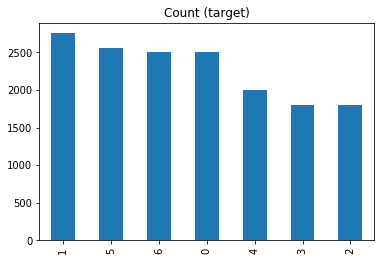

In [71]:
master_class_0_under = master_class_0.sample(2500)
master_class_4_under = master_class_4.sample(2000)
master_class_2_over = master_class_2.sample(1800, replace=True)
master_class_3_over = master_class_3.sample(1800, replace=True)
master_class_6_over = master_class_6.sample(2500, replace=True)

master_under = pd.concat([master_class_0_under, master_class_1, master_class_2_over, master_class_3_over, master_class_4_under, master_class_5, master_class_6_over], axis=0)

print('Random under & oversampling:')
print(master_under.emotion.value_counts())

master_under.emotion.value_counts().plot(kind='bar', title='Count (target)');


### Happy Path

In [42]:
hp = pd.read_csv('data/happypath/happypath_combined.csv', index_col='Unnamed: 0') 

In [43]:
hp.head()

,text,emotion
0,I feel a little angry,1
1,I'm a little angry,1
2,I feel kind of angry,1
3,I'm kind of angry,1
4,I feel sort of angry,1


In [44]:
class_dist_hp = hp.groupby('emotion').count()
class_dist_hp

,text
emotion,
1,840
2,392
3,1512
4,1792
5,896
7,644


In [47]:
hp = hp[hp.emotion != 7]

In [48]:
class_dist_hp = hp.groupby('emotion').count()
class_dist_hp

,text
emotion,
1,840
2,392
3,1512
4,1792
5,896


In [72]:
master_hp = pd.concat([master_under, hp])

In [76]:
master_hp.shape

(21347, 2)

In [78]:
master_hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21347 entries, 32194 to 5431
Data columns (total 2 columns):
text       21347 non-null object
emotion    21347 non-null int64
dtypes: int64(1), object(1)
memory usage: 500.3+ KB


In [79]:
master_hp.reset_index(drop=True, inplace=True)

In [80]:
master_hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21347 entries, 0 to 21346
Data columns (total 2 columns):
text       21347 non-null object
emotion    21347 non-null int64
dtypes: int64(1), object(1)
memory usage: 333.7+ KB


In [73]:
class_dist_master_hp = master_hp.groupby('emotion').count()
class_dist_master_hp

,text
emotion,
0,2500
1,3593
2,2192
3,3312
4,3792
5,3458
6,2500


Text(0, 0.5, 'Number of Instances')

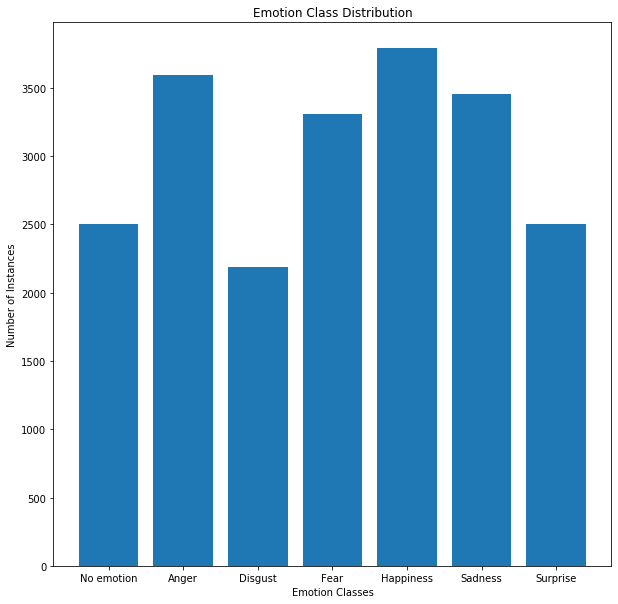

In [74]:
emotions = ['No emotion', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
plt.figure(figsize=(10,10))
plt.bar(class_dist_master_hp.index, class_dist_master_hp['text'], tick_label=emotions)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')

In [81]:
master_hp.to_pickle('data/master_under.pickle')